In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("taxi-analysis").getOrCreate()

24/07/12 11:02:22 WARN Utils: Your hostname, MZC01-HYUCKSANGCHO.local resolves to a loopback address: 127.0.0.1; using 10.90.9.46 instead (on interface en0)
24/07/12 11:02:22 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/07/12 11:02:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
trip_files = "/Users/mzc01-hyucksangcho/Downloads/trips/*"
zone_file = "/Users/mzc01-hyucksangcho/Downloads/taxi_zone_lookup.csv"

trips_df = spark.read.parquet(f"file:///{trip_files}", inferSchema=True, header = True)
zone_df = spark.read.csv(f"file:///{zone_file}", inferSchema=True, header = True)

In [3]:
trips_df.createOrReplaceTempView("trips")
zone_df.createOrReplaceTempView("zone")

In [4]:
print(trips_df.printSchema())
print(zone_df.printSchema())

root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = true)

None
root
 |-- LocationID: integer (nullable = true)
 |-- Borough: string (nullable = true)
 |-- Zone: string (nullable = true)
 |

In [18]:
query = """
SELECT
    t.VendorID as vendor_id,
    TO_DATE(t.tpep_pickup_datetime) as pickup_date,
    TO_DATE(t.tpep_dropoff_datetime) as dropoff_date,
    HOUR(t.tpep_pickup_datetime) as pickup_time,
    HOUR(t.tpep_dropoff_datetime) as dropoff_time,
    t.passenger_count,
    t.trip_distance,
    t.fare_amount,
    t.tip_amount,
    t.tolls_amount,
    t.total_amount,
    t.payment_type,
    t.tpep_pickup_datetime as pickup_datetime,
    pz.Zone as pickup_zone,
    dz.Zone as dropoff_zone
from
    trips t
    LEFT JOIN
        zone pz
    ON
        t.PULocationID = pz.LocationID
    LEFT JOIN
        zone dz
    ON
        t.DOLocationID = dz.LocationID
"""
comb_df = spark.sql(query)
comb_df.show()

+---------+-----------+------------+-----------+------------+---------------+-------------+-----------+----------+------------+------------+------------+-------------------+--------------------+--------------------+
|vendor_id|pickup_date|dropoff_date|pickup_time|dropoff_time|passenger_count|trip_distance|fare_amount|tip_amount|tolls_amount|total_amount|payment_type|    pickup_datetime|         pickup_zone|        dropoff_zone|
+---------+-----------+------------+-----------+------------+---------------+-------------+-----------+----------+------------+------------+------------+-------------------+--------------------+--------------------+
|        1| 2021-04-01|  2021-04-01|          0|           0|            1.0|          8.4|       25.5|      5.85|         0.0|       35.15|           1|2021-04-01 00:00:18|        East Village|    Hamilton Heights|
|        1| 2021-04-01|  2021-04-01|          0|           0|            1.0|          0.9|        5.0|       0.0|         0.0|         

In [19]:
comb_df.createOrReplaceTempView("comb")

In [7]:
comb_df.printSchema()

root
 |-- vendor_id: long (nullable = true)
 |-- pickup_date: date (nullable = true)
 |-- dropoff_date: date (nullable = true)
 |-- pickup_time: integer (nullable = true)
 |-- dropoff_time: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- pickup_datetime: timestamp_ntz (nullable = true)
 |-- pickup_zone: string (nullable = true)
 |-- dropoff_zone: string (nullable = true)



In [8]:
spark.sql("SELECT pickup_date, pickup_time FROM comb WHERE pickup_time > 0").show()

+-----------+-----------+
|pickup_date|pickup_time|
+-----------+-----------+
| 2021-03-31|         23|
| 2021-03-31|         23|
| 2021-03-31|         23|
| 2021-03-31|         23|
| 2021-03-31|         23|
| 2021-03-31|         23|
| 2021-03-31|         23|
| 2021-03-31|         23|
| 2021-03-31|         23|
| 2021-04-01|          1|
| 2021-04-01|          1|
| 2021-04-01|          1|
| 2021-04-01|          1|
| 2021-04-01|          1|
| 2021-04-01|          1|
| 2021-04-01|          1|
| 2021-04-01|          1|
| 2021-04-01|          1|
| 2021-04-01|          1|
| 2021-04-01|          1|
+-----------+-----------+
only showing top 20 rows



In [10]:
spark.sql("SELECT pickup_date, pickup_time FROM comb WHERE pickup_date < '2020-12-31'").show()

+-----------+-----------+
|pickup_date|pickup_time|
+-----------+-----------+
| 2009-01-01|          3|
| 2009-01-01|         16|
| 2009-01-01|         11|
| 2009-01-01|         12|
| 2009-01-01|         12|
| 2008-12-31|         23|
| 2008-12-31|         23|
| 2009-01-01|          0|
| 2009-01-01|          0|
| 2009-01-01|          0|
| 2009-01-01|          1|
| 2009-01-01|          0|
| 2009-01-01|          0|
| 2009-01-01|         16|
| 2009-01-01|         16|
| 2009-01-01|          0|
| 2009-01-01|          0|
| 2009-01-01|          0|
| 2009-01-01|         19|
| 2009-01-01|         19|
+-----------+-----------+
only showing top 20 rows



In [11]:
comb_df.select("total_amount").describe().show()

+-------+------------------+
|summary|      total_amount|
+-------+------------------+
|  count|          15000936|
|   mean| 18.75540051097825|
| stddev|145.74310219085984|
|    min|            -647.8|
|    max|          398469.2|
+-------+------------------+



In [12]:
comb_df.select("trip_distance").describe().show()

+-------+-----------------+
|summary|    trip_distance|
+-------+-----------------+
|  count|         15000936|
|   mean|6.628556730059906|
| stddev|671.7240645480989|
|    min|              0.0|
|    max|        332541.19|
+-------+-----------------+



In [14]:
comb_df.select("passenger_count").describe().show()

+-------+------------------+
|summary|   passenger_count|
+-------+------------------+
|  count|          14166908|
|   mean|1.4253582362502812|
| stddev|1.0443336003189165|
|    min|               0.0|
|    max|               9.0|
+-------+------------------+



In [16]:
query = """
SELECT
    DATE_TRUNC('MM', c.pickup_date) AS month,
    count(*) AS trips
FROM
    comb c
GROUP BY
    month
ORDER BY
    month desc
"""
spark.sql(query).show()

+-------------------+-------+
|              month|  trips|
+-------------------+-------+
|2029-05-01 00:00:00|      1|
|2021-12-01 00:00:00|      5|
|2021-11-01 00:00:00|      5|
|2021-10-01 00:00:00|      3|
|2021-09-01 00:00:00|      3|
|2021-08-01 00:00:00|     36|
|2021-07-01 00:00:00|2821661|
|2021-06-01 00:00:00|2834204|
|2021-05-01 00:00:00|2507075|
|2021-04-01 00:00:00|2171215|
|2021-03-01 00:00:00|1925130|
|2021-02-01 00:00:00|1371689|
|2021-01-01 00:00:00|1369753|
|2020-12-01 00:00:00|     16|
|2009-01-01 00:00:00|    111|
|2008-12-01 00:00:00|     26|
|2004-04-01 00:00:00|      1|
|2003-01-01 00:00:00|      1|
|2002-12-01 00:00:00|      1|
+-------------------+-------+



In [20]:
# Data Cleaning
query = """
SELECT
    *
FROM
    comb c
WHERE
    c.total_amount < 5000
    AND c.total_amount > 9
    AND c.trip_distance < 100
    AND c.passenger_count < 4
    AND c.pickup_date >= '2021-01-01'
    AND c.pickup_date < '2021-08-01'
"""
clean_df = spark.sql(query)
clean_df.createOrReplaceTempView("cleaned")

In [21]:
clean_df.describe().show()

24/07/12 11:15:08 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-------------------+------------------+-----------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+--------------------+--------------------+
|summary|          vendor_id|       pickup_time|     dropoff_time|   passenger_count|     trip_distance|       fare_amount|       tip_amount|      tolls_amount|      total_amount|      payment_type|         pickup_zone|        dropoff_zone|
+-------+-------------------+------------------+-----------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+--------------------+--------------------+
|  count|           12186940|          12186940|         12186940|          12186940|          12186940|          12186940|         12186940|          12186940|          12186940|          12186940|            12186940|            12186940|
|   mean| 1.6723880646003015|14.2804

In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [25]:
query = """
SELECT
    c.pickup_date,
    count(*) as trips
FROM
    cleaned c
GROUP BY
    c.pickup_date
"""
pd_df = spark.sql(query).toPandas()
pd_df.head()

,pickup_date,trips
0,2021-04-29,67758
1,2021-04-24,64373
2,2021-07-19,73731
3,2021-04-25,39679
4,2021-04-21,64938


<AxesSubplot:xlabel='pickup_date', ylabel='trips'>

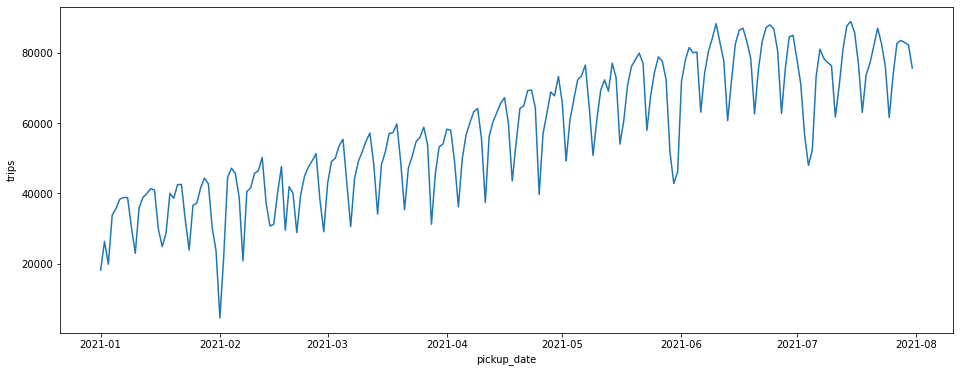

In [27]:
fig, ax = plt.subplots(figsize=(16,6))
sns.lineplot(x="pickup_date", y="trips", data=pd_df)

In [29]:
query = """
SELECT
    c.pickup_date,
    DATE_FORMAT(c.pickup_date, 'EEEE') AS day_of_week,
    count(*) as trips
FROM
    cleaned c
GROUP BY
    c.pickup_date,
    day_of_week
"""
pd_df2 = spark.sql(query).toPandas()
pd_df2.head()

,pickup_date,day_of_week,trips
0,2021-04-23,Friday,69456
1,2021-04-11,Sunday,37386
2,2021-04-26,Monday,56965
3,2021-04-10,Saturday,55656
4,2021-04-22,Thursday,69257


In [30]:
data = pd_df2.groupby("day_of_week").trips.median().to_frame().reset_index()
data["sort_dow"] = data['day_of_week'].replace({
    "Sunday": 0,
    "Monday": 1,
    "Tuesday": 2,
    "Wednesday": 3,
    "Thursday": 4,
    "Friday": 5,
    "Saturday": 6,
})

In [33]:
data.sort_values(by='sort_dow', inplace=True)

In [34]:
data

,day_of_week,trips,sort_dow
3,Sunday,38532.5,0
1,Monday,51058.5,1
5,Tuesday,61555.5,2
6,Wednesday,63969.0,3
4,Thursday,66725.0,4
0,Friday,67232.0,5
2,Saturday,55656.0,6


<AxesSubplot:xlabel='day_of_week', ylabel='trips'>

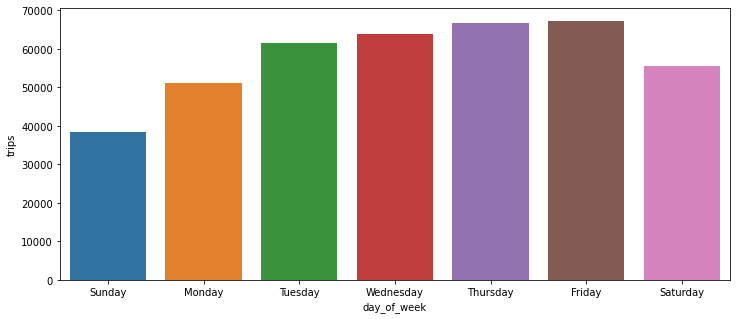

In [35]:
fig, ax = plt.subplots(figsize=(12,5))
sns.barplot(x="day_of_week", y="trips", data=data)